In [80]:
import os 
from  dotenv import load_dotenv 
from langchain_google_genai import ChatGoogleGenerativeAI

# get google api key from .env
load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")

# initializing the Gemini Model
llm = ChatGoogleGenerativeAI(api_key=api_key, model="gemini-pro")

In [81]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list, add_messages]

In [82]:
from langgraph.graph import StateGraph, START , END


graph_builder = StateGraph(State)

In [83]:
def chatbot(state: State) -> State:
    return {
        "messages" : [llm.invoke(state["messages"])]
    }

graph_builder.add_node("chatbot", chatbot)

In [84]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

In [85]:
graph = graph_builder.compile()

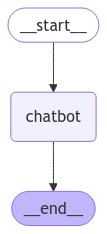

In [86]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [87]:
res = graph.stream({
    "messages" : [(
        "user", "Hi I am Zaka"
    )]
})

for event in res:
    for value in event.values():
        print("Assistant: ", value["messages"][-1].content)




Assistant:  Hello Zaka, it's nice to meet you. I am Gemini, a multi-modal AI model, developed by Google. Is there anything I can assist you with today?


Enhancing with tools


In [88]:
load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [89]:
from langchain_community.tools.tavily_search import TavilySearchResults 

tool = TavilySearchResults(max_results=1)
tools = [tool]


In [90]:
# we will use our previous llm that we created earlier

llm_with_tools = llm.bind_tools(tools)

# now we will create a new chatbot 
def chatbot(state: State) -> State:
    return {
        "messages" : [llm_with_tools.invoke(state["messages"])]
    }


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)


In [91]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [92]:
from typing import Literal


def route_tools(state: State) :
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("No message found in input state ot tool_edge: ", state)
    

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


graph_builder.add_conditional_edges(
    "chatbot", route_tools,
    {"tools" : "tools", END : END}
)


graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

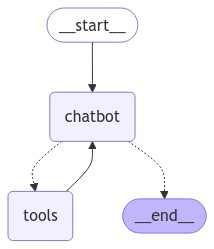

In [93]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [98]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello. How can I help you today?
Assistant: Hello there. How can I help you today?
Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Islamabad', 'region': 'Islamabad', 'country': 'Pakistan', 'lat': 33.7, 'lon': 73.167, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1731873692, 'localtime': '2024-11-18 01:01'}, 'current': {'last_updated_epoch': 1731873600, 'last_updated': '2024-11-18 01:00', 'temp_c': 13.5, 'temp_f': 56.3, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 5.4, 'wind_kph': 8.6, 'wind_degree': 24, 'wind_dir': 'NNE', 'pressure_mb': 1015.0, 'pressure_in': 29.99, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 37, 'cloud': 0, 'feelslike_c': 13.0, 'feelslike_f': 55.4, 'windchill_c': 13.0, 'windchill_f': 55.4, 'heatindex_c': 13.5, 'heatindex_f': 56.3, 'dewpoint_c': -1.0, 'dewpoint_f': 30.3, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.0, 'gust_m

adding memory

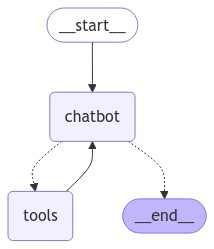

In [99]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_builder = StateGraph(State)



graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [100]:
config = {"configurable": {"thread_id": "1"}}

In [106]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will, how can I help you today?


In [107]:
user_input = "what is my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

Your name is Will.


## Human in the loop

In [113]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [114]:

# Now, compile the graph, specifying to interrupt_before the tools node.

graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [118]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "3"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a45c73d3-4ba4-45d6-a176-f329be9a8d5b)
 Call ID: a45c73d3-4ba4-45d6-a176-f329be9a8d5b
  Args:
    query: LangGraph


In [119]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a45c73d3-4ba4-45d6-a176-f329be9a8d5b)
 Call ID: a45c73d3-4ba4-45d6-a176-f329be9a8d5b
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Platform is a service for deploying and scaling LangGraph applications, with an opinionated API for building agent UXs, plus an integrated developer studio."}]
================================== Ai Message ==================================

LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Platform is a service for deploying and scaling LangGraph applications, with an opinionated API for building agent UXs, plus an integrat

## Updating the state manually 

In [123]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "3"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c2dd9274-f543-4bf4-93e8-167cd7b3768b)
 Call ID: c2dd9274-f543-4bf4-93e8-167cd7b3768b
  Args:
    query: LangGraph


In [124]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c2dd9274-f543-4bf4-93e8-167cd7b3768b)
 Call ID: c2dd9274-f543-4bf4-93e8-167cd7b3768b
  Args:
    query: LangGraph


In [125]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)

new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

In [126]:
new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [127]:
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa5216-f57d-6d13-8007-1e86bc23c515'}}

In [136]:
from pprint import pprint

print("Messages: \n ")
pprint(graph.get_state(config).values["messages"][-4:])

Messages: 
 
[HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='49c2f8db-0ee5-4170-81fa-df8b717883f9'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-cfd80375-c2cb-44e5-a7f5-86d0ab76037f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'c2dd9274-f543-4bf4-93e8-167cd7b37

in the above example, we updated our state by appending messages, now we will update state by replacing older messages

In [141]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "6"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavilly_search_results_json (d8c6e55d-1dc3-4dd1-a438-b2bca058ac3f)
 Call ID: d8c6e55d-1dc3-4dd1-a438-b2bca058ac3f
  Args:
    query: What is LangGraph


In [142]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-0035945e-0646-4fcc-9103-5c3d4ec79835-0
{'name': 'tavilly_search_results_json', 'args': {'query': 'What is LangGraph'}, 'id': 'd8c6e55d-1dc3-4dd1-a438-b2bca058ac3f', 'type': 'tool_call'}
Updated
{'name': 'tavilly_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'd8c6e55d-1dc3-4dd1-a438-b2bca058ac3f', 'type': 'tool_call'}
Message ID run-0035945e-0646-4fcc-9103-5c3d4ec79835-0


Tool calls


[{'name': 'tavilly_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'd8c6e55d-1dc3-4dd1-a438-b2bca058ac3f',
  'type': 'tool_call'}]

In [143]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavilly_search_results_json (d8c6e55d-1dc3-4dd1-a438-b2bca058ac3f)
 Call ID: d8c6e55d-1dc3-4dd1-a438-b2bca058ac3f
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavilly_search_results_json

Error: tavilly_search_results_json is not a valid tool, try one of [tavily_search_results_json].
================================== Ai Message ==================================

I cannot fulfill this request. The available tools lack the desired functionality.


So far, we've relied on a simple state (it's just a list of messages!). You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. In this section, we will extend our chat bot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph always interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.

In [144]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [145]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [153]:
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


In [154]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [155]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [156]:
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [157]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [158]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

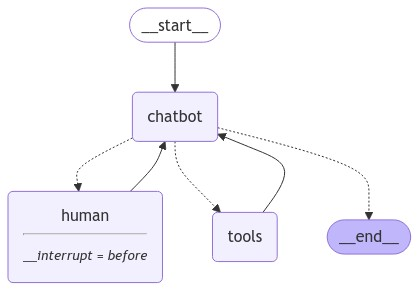

In [159]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [160]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "6"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (531f02de-f765-476f-a9a7-0df64fd1e4d7)
 Call ID: 531f02de-f765-476f-a9a7-0df64fd1e4d7
  Args:
    request: I need some expert guidance for building this AI agent.


In [161]:
# Notice: the LLM has invoked the "RequestAssistance" tool we provided it,
#  and the interrupt has been set.
#  Let's inspect the graph state to confirm.
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [162]:
# now we will act as a human  
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa52bb-1599-68df-8002-46b78bc60bf8'}}

In [163]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='017f9ec4-aa75-4ade-aa77-829f5fdd1e96'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need some expert guidance for building this AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-95760f4a-5dd9-4887-9a58-32d62d390c3e-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need

In [168]:
# Next, resume the graph by invoking it with None as the inputs.
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        pprint(event["messages"])

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='017f9ec4-aa75-4ade-aa77-829f5fdd1e96'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need some expert guidance for building this AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-95760f4a-5dd9-4887-9a58-32d62d390c3e-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need

## Time Travel

In [173]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [174]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-2].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (531f02de-f765-476f-a9a7-0df64fd1e4d7)
 Call ID: 531f02de-f765-476f-a9a7-0df64fd1e4d7
  Args:
    request: I need some expert guidance for building this AI agent.
================================= Tool Message =================================

No response from human.
